In [1]:
import pandas
import datetime
import numpy
import time
import bs4
import urllib
import seaborn
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
# get dst index vals from wdc kyoto website
# create a list of dates with monthly freq
date_dst_arr = []
dst_val = []
dst_time_del = datetime.timedelta(hours = 1)
start_date = datetime.datetime(2011,1,1)
end_date = datetime.datetime(2014,12,31)
daterange = pandas.date_range(start_date, end_date, freq="M")
for dt in daterange:
    if dt.month <= 9:
            monthStr = "0" + str(dt.month)
    else:
        monthStr = str(dt.month)
    if dt.year >= 2015:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_realtime" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    elif ( (dt.year > 2011) and (dt.year < 2015) ):
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_provisional" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    else:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_final" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    conn = urllib.urlopen(currUrl)
    htmlSource = conn.read()
    soup = bs4.BeautifulSoup(htmlSource, 'html.parser')
    dataResObj = soup.find("pre", { "class" : "data" })
    # get the data as a list of strings after removing white space
    lines = dataResObj.text.strip().splitlines()
    for line in lines[6:]:
        columns = line.split()
        if len( columns ) > 0. :
            date_dst_arr.append( datetime.datetime( \
                dt.year, dt.month, int(columns[0]), 1 ) )
            for cols in range( len( columns[1:] ) ) :
                try:
                    inNumberFloatTest = float(columns[cols + 1])
                except:
                    # split these cols as well and work on them!
                    try:
                        missedCols = columns[cols + 1].split("-")[1:]
                        if len(missedCols) >= 1:
                            for mcols in missedCols:
                                dst_val.append( -1*float( mcols ) )
                                # now since we added the date earlier we need to be
                                # careful about appending date values
                                if ( len(date_dst_arr) != len(dst_val) ):
                                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
                    except:
                        print "something wrong with messed up vals!-->", columns[cols + 1]
                        continue
                    continue
                # I have to do this because of the messed up way Kyoto puts up the latest dst value..
                # mixed with 9999 (fillers) like if latest dst is 1 then Kyoto puts it as 199999.....
                if len( columns[ cols + 1 ] ) < 5 :
                    dst_val.append( float( columns[ cols + 1 ] ) )
                elif ( len( columns[ cols + 1 ] ) > 5 and columns[ cols + 1 ][0:3] != '999' ) :
                    mixed_messed_dst = ''
                    for jj in range(5) :
                        if columns[ cols + 1 ][jj] != '9' :
                            mixed_messed_dst = mixed_messed_dst + columns[ cols + 1 ][jj]

                    if mixed_messed_dst != '-' :
                        dst_val.append( float( mixed_messed_dst ) )
                    else :
                        dst_val.append( float( 'nan' ) )
                else :
                    dst_val.append( float( 'nan' ) )
                if cols > 0 :
                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
# convert dst data to a dataframe
dstDF = pandas.DataFrame(
    {'dst_date': date_dst_arr,
     'dst_index': dst_val
    })
dstDF.head()

,dst_date,dst_index
0,2011-01-01 01:00:00,-11.0
1,2011-01-01 02:00:00,-11.0
2,2011-01-01 03:00:00,-9.0
3,2011-01-01 04:00:00,-5.0
4,2011-01-01 05:00:00,-3.0


In [3]:
# file containing saps data --> date, time, sapsLat, sapsMLT, sapsVel, radId, poesLat, poesMLT
#file_sapsdata = "/Users/bharat/Desktop/saps-north-2011-2012.txt"
file_sapsdata = "../data/rawsaps-north-2011-2014.txt"
# store the data to convert it to DF later
allData = []
# open and read through the file
fs = open(file_sapsdata, 'r')
# only take data from mid-latitude radars
midlatRadIds = [209, 208, 33, 207, 206, 205, 204, 32]
for line in fs:
    line = line.strip()
    columns = line.split()
    
    dt_ind = time.strptime( columns[0], "%Y%m%d" )
    hh_ind = int(int(columns[1])/100)
    mm_ind = int(int(columns[1]) % 100)
    currDt = datetime.datetime( dt_ind.tm_year, dt_ind.tm_mon, dt_ind.tm_mday, hh_ind, mm_ind )
    allData.append( [ columns[0] + "-" + columns[1], currDt, columns[0], \
                     float( columns[2] ), float( columns[3] ), float( columns[4] ), \
                     float( columns[5] ), float( columns[6] ), float( columns[7] ) ] )  
fs.close()
# store data in a DF
sapsRawDF = pandas.DataFrame(allData)
sapsRawDF.columns = [ "dateTimeString", "date", "dateStr", "sapsLat", \
                     "sapsMLT", "sapsVel", "radId", "poesLat", "poesMLT" ]
# count number of unique dates present in the raw DF
uniqRawDates = sapsRawDF["dateStr"].unique().tolist()
print "num of unique(total) dates--->", len(uniqRawDates)
sapsRawDF.head()

num of unique(total) dates---> 1320


,dateTimeString,date,dateStr,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT
0,20110101-100,2011-01-01 01:00:00,20110101,61.5,2.7764,336.5572,10.0,65.4015,3.0
1,20110101-230,2011-01-01 02:30:00,20110101,61.5,4.5593,254.1402,10.0,66.2104,5.0
2,20110101-700,2011-01-01 07:00:00,20110101,54.5,1.7927,639.8867,33.0,67.2811,2.0
3,20110101-700,2011-01-01 07:00:00,20110101,54.5,1.9076,650.9573,33.0,67.2811,2.0
4,20110101-700,2011-01-01 07:00:00,20110101,55.5,1.8949,653.0461,33.0,67.2811,2.0


In [4]:
# create a date string and time column for the dst DF
dstDF["dateStr"] = dstDF["dst_date"].map(lambda x: x.strftime('%Y%m%d'))
dstDF["hour"] = dstDF["dst_date"].map(lambda x: x.strftime('%H'))
# Make an hour column for the sapsRawDF too
sapsRawDF["hour"] = sapsRawDF["date"].map(lambda x: x.strftime('%H'))
# Now merge the dst and sapsRaw DFs
sapsRawDF = pandas.merge( sapsRawDF, dstDF, on=["dateStr", "hour"], how='inner')
sapsRawDF.head()

,dateTimeString,date,dateStr,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,hour,dst_date,dst_index
0,20110101-100,2011-01-01 01:00:00,20110101,61.5,2.7764,336.5572,10.0,65.4015,3.0,01,2011-01-01 01:00:00,-11.0
1,20110101-230,2011-01-01 02:30:00,20110101,61.5,4.5593,254.1402,10.0,66.2104,5.0,02,2011-01-01 02:00:00,-11.0
2,20110101-700,2011-01-01 07:00:00,20110101,54.5,1.7927,639.8867,33.0,67.2811,2.0,07,2011-01-01 07:00:00,-5.0
3,20110101-700,2011-01-01 07:00:00,20110101,54.5,1.9076,650.9573,33.0,67.2811,2.0,07,2011-01-01 07:00:00,-5.0
4,20110101-700,2011-01-01 07:00:00,20110101,55.5,1.8949,653.0461,33.0,67.2811,2.0,07,2011-01-01 07:00:00,-5.0


In [5]:
# Get dst wise days
# count number of (saps) dates present in the processed DF
uniqTotalDates = sapsRawDF["dateStr"].unique().tolist()
print "num of saps dates--->", len(uniqTotalDates)
# get daywise min Dst
allDatesDstGrps = sapsRawDF.groupby(["dateStr"])
minDstAllDataDaywise = allDatesDstGrps["dst_index"].min()
# We'll use the pandas cut function to bin the data
# our bins are --> [-10,10], [-25,-10], [-50,-25], [-75,-50], [-125,-75]
bins = [-150,-75,-50,-25,-10,10]
allDataDayWiseBins = pandas.cut( minDstAllDataDaywise, bins=bins )
print pandas.value_counts( allDataDayWiseBins )

num of saps dates---> 1320
(-10, 10]      553
(-25, -10]     455
(-50, -25]     212
(-75, -50]      51
(-150, -75]     24
Name: dst_index, dtype: int64


In [6]:
# Instead of the daywise thing we'll do an hourwise analysis too!
allDatesDstGrps = sapsRawDF.groupby(["dateStr", "hour"])
minDstAllDataHourwise = allDatesDstGrps["dst_index"].aggregate(lambda x: set(tuple(x))).reset_index()
# Below is just a sanity check to verify the joins are working fine
# Basically we shouldn't have more than 1 Dst index
minDstAllDataHourwise["checkSameDst"] = minDstAllDataHourwise["dst_index"].map(\
                                    lambda x: len(x) > 1 )
if (minDstAllDataHourwise[ minDstAllDataHourwise[ "checkSameDst" ] == True ]["dst_index"].count() == 0):
    print "JOIN WENT WELL LOOKE FINE!"
else:
    print "NEED TO CHECK THE CODE! MAJORRRR PROBLEMMMMM!"
minDstAllDataHourwise["dst_index"] = minDstAllDataHourwise["dst_index"].map(\
                                    lambda x: x.pop() )

JOIN WENT WELL LOOKE FINE!


In [7]:
allDataHourWiseBins = pandas.cut( minDstAllDataHourwise, bins=bins )
print pandas.value_counts( allDataHourWiseBins )

(-10, 10]      14974
(-25, -10]      3067
(-50, -25]      1410
(-75, -50]       265
(-150, -75]      133
dtype: int64


In [8]:
# # Try a new method to filter for the SAPS events
# # Involves 3 filters : 
# # 1) get data from only mid-lat radars
sapsRawDF = sapsRawDF[ sapsRawDF["radId"].isin(midlatRadIds) ]
sapsRawDF = sapsRawDF[ sapsRawDF["dst_index"] <= 10.] 
# # 2) The saps event should be observed by atleast 4 mid-latitude radars on a given day
sapsNumRadsSer = sapsRawDF.groupby( ["dateStr"] ).agg( {"radId": pandas.Series.nunique} )
sapsNumRadsSer = sapsNumRadsSer[ sapsNumRadsSer >= 4  ].dropna().reset_index()
sapsNumRadsSer.columns = [ "dateStr", "nRads" ]
# Number of data points on a given date should be greater than 200!
sapsDateTimeCount = sapsRawDF.groupby(["dateStr"]).count()
sapsDateTimeCount = sapsDateTimeCount[ \
                        sapsDateTimeCount["sapsLat"] >= 200 ][ ["dateTimeString"] ].reset_index()
sapsDateTimeCount.columns = [ "dateStr", "nSapsVecs" ]
# Merge both the data points
sapsDateSelDF = pandas.merge( sapsDateTimeCount, sapsNumRadsSer, on="dateStr" )
# Now merge dates selected and saps raw DFs
sapsRawDF = pandas.merge( sapsRawDF, sapsDateSelDF, on="dateStr" )

prcsdSapsDF = sapsRawDF[ ["dateStr", "hour","sapsLat", \
                     "sapsMLT", "sapsVel", "radId", "poesLat", "poesMLT", "dst_date", "dst_index"] ]

prcsdSapsDF["time"] = sapsRawDF["date"].map(lambda x: x.strftime('%H%M'))
# Save to a new model file
prcsdSapsDF.to_csv("../data/processedSaps-new.txt", sep=' ', index=False)
prcsdSapsDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,dateStr,hour,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,dst_date,dst_index,time
0,20110107,00,56.5,17.7543,308.2077,33.0,62.0082,18.0,2011-01-07,-18.0,0000
1,20110107,00,55.5,18.0147,224.1588,33.0,62.0082,18.0,2011-01-07,-18.0,0000
2,20110107,00,56.5,17.8749,307.4328,33.0,62.0082,18.0,2011-01-07,-18.0,0000
3,20110107,00,55.5,18.1324,222.4787,33.0,62.0082,18.0,2011-01-07,-18.0,0000
4,20110107,00,56.5,17.9955,305.4201,33.0,62.0082,18.0,2011-01-07,-18.0,0000


In [9]:
# # dates = pandas.DatetimeIndex(sapsRawDF.date)
# # # get data from only mid-lat radars
# sapsRawDF = sapsRawDF[ sapsRawDF["radId"].isin(midlatRadIds) ]
# # sapsRawDF.reset_index(inplace=True, drop=True)
# sapsDateGrp = sapsRawDF.groupby(["dateStr"])
# numSapsDates = sapsDateGrp["dateTimeString"].count()
# # # get a list of SAPS dates where num of 
# # # observations is greater than 200.
# numSapsDates = numSapsDates[ numSapsDates > 200 ]
# sapsDatesList = numSapsDates.index.tolist()
# # # get only data points from the selected dates
# sapsRawDF = sapsRawDF[sapsRawDF["dateStr"].isin(sapsDatesList)].reset_index(drop=True)
# # get a df with proper format
# prcsdSapsDF = sapsRawDF[ ["dateStr", "hour","sapsLat", \
#                      "sapsMLT", "sapsVel", "radId", "poesLat", "poesMLT", "dst_date", "dst_index"] ]
# prcsdSapsDF["time"] = sapsRawDF["date"].map(lambda x: x.strftime('%H%M'))
# prcsdSapsDF.head()

In [10]:
# count number of (saps) dates present in the processed DF
uniqSapsDates = prcsdSapsDF["dateStr"].unique().tolist()
print "num of saps dates--->", len(uniqSapsDates)

num of saps dates---> 311


In [11]:
# get daywise min Dst
sapsDFHourDstGrps = prcsdSapsDF.groupby(["dateStr", "hour"])
minDstHourwise = sapsDFHourDstGrps["dst_index"].min()
# We'll use the pandas cut function to bin the data
# our bins are --> [-10,10], [-25,-10], [-50,-25], [-75,-50], [-125,-75]
bins = [-150,-75,-50,-25,-10,10]
hourWiseBins = pandas.cut( minDstHourwise, bins=bins )
print pandas.value_counts(hourWiseBins)
print pandas.value_counts( allDataHourWiseBins )

(-25, -10]     1089
(-50, -25]      924
(-10, 10]       686
(-75, -50]      230
(-150, -75]     124
Name: dst_index, dtype: int64
(-10, 10]      14974
(-25, -10]      3067
(-50, -25]      1410
(-75, -50]       265
(-150, -75]      133
dtype: int64


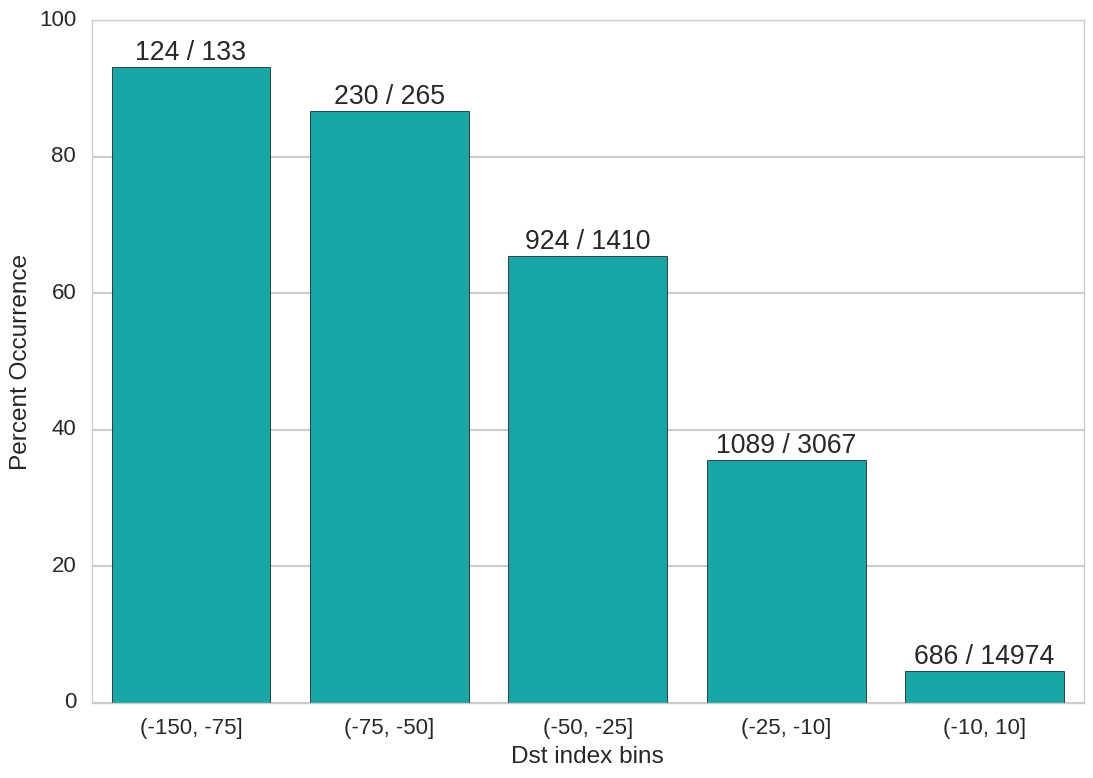

In [12]:
# set seaborn color
seaborn.set_style("whitegrid")
seaborn.set_context("poster")
dstSapsHoursDF = pandas.concat([ \
                     pandas.value_counts( hourWiseBins ), \
                     pandas.value_counts( allDataHourWiseBins )],\
                    axis=1)#.reset_index()
dstSapsHoursDF = dstSapsHoursDF.reindex(index = ['(-150, -75]','(-75, -50]',\
                                               '(-50, -25]', '(-25, -10]', '(-10, 10]']).reset_index()
dstSapsHoursDF.columns = [ "dstRange", "sapsdays", "totaldays" ]
dstSapsHoursDF["sapsPercent"] = dstSapsHoursDF["sapsdays"]*100/dstSapsHoursDF["totaldays"]
# colors - dodgerblue, lightseagreen, palevioletred, skyblue, c
hoursBar = seaborn.barplot( dstSapsHoursDF["dstRange"], dstSapsHoursDF["sapsPercent"], color="c" )
plt.ylim(0, 100)
plt.xlabel("Dst index bins")
plt.ylabel("Percent Occurrence")
for n,p in enumerate(hoursBar.patches):
    titStrg = str( dstSapsHoursDF["sapsdays"][n] ) +\
        " / " + str( dstSapsHoursDF["totaldays"][n] )
    hoursBar.annotate(
        s= titStrg,
        xy=(p.get_x()+p.get_width()/2.,p.get_height()),
        ha='center',va='center',
        xytext=(0,10),
        textcoords='offset points'
)
fig = hoursBar.get_figure()
fig.savefig("../figs/hoursPercent.pdf",bbox_inches='tight')

In [13]:
# Instead of bins go for dst vs percent analysis plot
dstHourDF = minDstAllDataHourwise.groupby( ["dst_index"] ).count().reset_index()[["dst_index", "dateStr"]]
dstHourDF.columns = [ "dst_index", "count_total" ]
dstHourDF.head()
sapsDFHourDstGrps = prcsdSapsDF.groupby(["dateStr", "hour"])
dstHourwise = sapsDFHourDstGrps["dst_index"].min().reset_index()
dstHourwise = dstHourwise.drop_duplicates()
dstSapsHourwise = dstHourwise.groupby( ["dst_index"] ).count().reset_index()[["dst_index", "dateStr"]]
dstSapsHourwise.columns = [ "dst_index", "count_saps" ]
dstSapsHourwise.head()
# Merge the DFs to get percent saps occ
dstSapsHourwise = pandas.merge( dstHourDF, dstSapsHourwise, on=["dst_index"], how='inner')
dstSapsHourwise["percent"] = dstSapsHourwise["count_saps"] *100./ dstSapsHourwise["count_total"]
dstSapsHourwise.tail()

,dst_index,count_total,count_saps,percent
125,6.0,153,23,15.032680
126,7.0,155,16,10.322581
127,8.0,109,19,17.431193
128,9.0,107,14,13.084112
129,10.0,72,10,13.888889


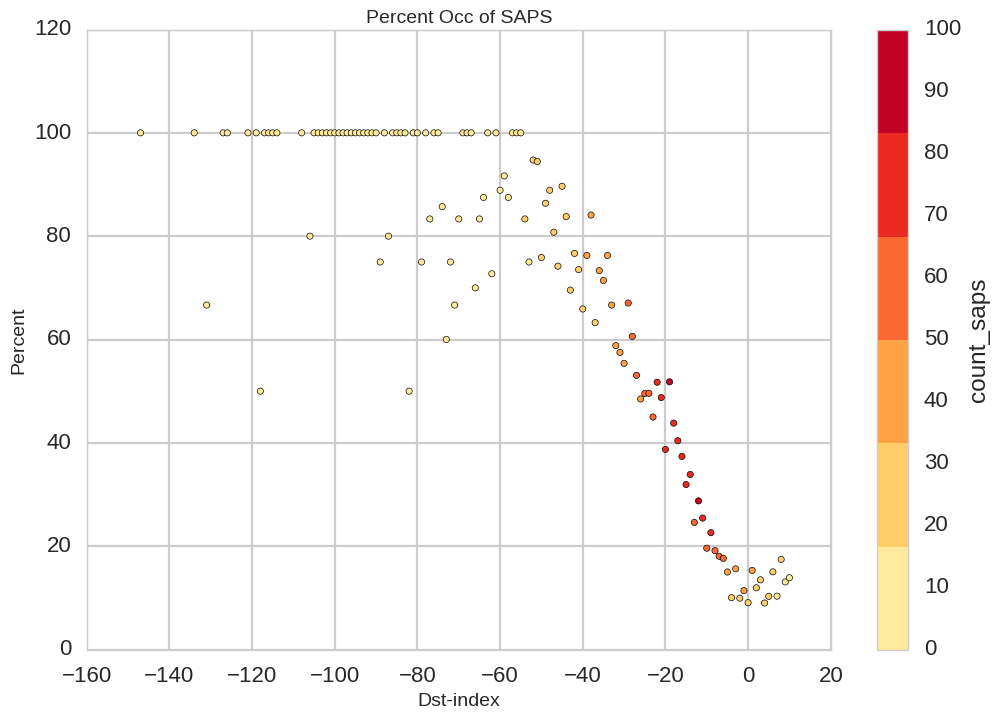

In [14]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

# seaborn.set_style("darkgrid")
# seaborn.set_context("paper")
seaMap = ListedColormap(seaborn.color_palette("YlOrRd"))
aa = dstSapsHourwise.plot( kind='scatter',
              x='dst_index',
              y='percent',
              c='count_saps', vmin=0, vmax=100,cmap=seaMap, ax=ax1)
ax1.set_ylabel("Percent", fontsize=14)
ax1.set_xlabel("Dst-index", fontsize=14)
ax1.set_title( "Percent Occ of SAPS", fontsize=14 )
plt.savefig("../figs/sapsPercent.pdf",bbox_inches='tight')